In [ ]:
import numpy as np
from pysr import PySRRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from data_preprocessing import data_preprocess
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from sympy import pretty

: 

In [3]:
def r2_calc(y, y_pred):
    r2 =r2_score(y, y_pred)
    print("R2 score: ", r2)
    return r2, y, y_pred

def mse_calc(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error: ", mse)
    return mse

def error_percentage(y, y_pred):
    percentage = np.abs((y - y_pred) / y) * 100
    # delete inf values in percentage
    percentage = percentage[percentage != np.inf]
    error = np.mean(percentage)
    print("Mean Absolute Percentage Error: ", error)
    return error

# detect outliers using 3 standard deviation
def detect_outliers(data, threshold=3):
    mean = np.mean(data['delta_phi'])
    std_dev = np.std(data['delta_phi'])
    outliers = []
    for i in data['delta_phi']:
        z_score = (i - mean) / std_dev
        if np.abs(z_score) > threshold:
            outliers.append(i)
    data_without_outliers = data[~data['delta_phi'].isin(outliers)]
    return data_without_outliers


In [36]:
argon = pd.read_csv('data/real_ufrac_argon.csv')
water = pd.read_csv('data/real_ufrac_water.csv')
methane = pd.read_csv('data/real_ufrac_methane.csv')
total_data_features = pd.read_csv('data/processed_data/combined_data_add_features_3_filtered_normalized.csv')
#total_data_features=data_preprocess.formula_constraint(total_data_features)
# drop Unnamed: 0 column
argon = argon.drop(columns=['Unnamed: 0'])
water = water.drop(columns=['Unnamed: 0'])
methane = methane.drop(columns=['Unnamed: 0'])

In [5]:
def formula_constraint_0(data):
    data.loc[data['density'] == 0, 'delta_phi'] = 0
    return data
total_data_features = formula_constraint_0(total_data_features)

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Example DataFrame similar to yours
# Load your data
df = total_data_features.copy()  # replace with your actual data file path

# Select the columns that you don't want to standardize
exclude_columns = ['Boiling_Point', 'Molecular_Weight', 'Melting_Point']

# Create a list of columns to standardize by excluding the selected columns
columns_to_standardize = [col for col in df.columns if col not in exclude_columns]

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Standardize only the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

# Display the standardized DataFrame
df.head()


,density,temperature,Molecular_Weight,Density,Boiling_Point,Melting_Point,delta_phi
0,0.000000,0.210526,18.015,1.0,100.0,0.0,1.000000
1,1.000000,0.210526,18.015,1.0,100.0,0.0,0.027681
2,0.000000,0.276316,18.015,1.0,100.0,0.0,0.385586
3,0.979798,0.276316,18.015,1.0,100.0,0.0,0.028061
4,0.989899,0.276316,18.015,1.0,100.0,0.0,0.028069


In [28]:
df['temperature'].min()

0.0

In [5]:
water_without_outliers = detect_outliers(water)
len_water = len(water)
len_water_without_outliers = len(water_without_outliers)
print("Number of outliers in water data: ", len_water - len_water_without_outliers)

Number of outliers in water data:  3


In [6]:
def argon_sample(argon, sample_frac):
    argon_sample = pd.DataFrame({})
    Temperatures = argon['temperature'].unique()
    for T in Temperatures:
        if T < 200:
            data = argon[argon['temperature'] == T]
            argon_sample = pd.concat([argon_sample, data])
        if T>=200:
            data = argon[argon['temperature'] == T].sample(frac = sample_frac)
            argon_sample = pd.concat([argon_sample, data])
    print("length of original argon data: ", len(argon), "length of sampled argon data: ", len(argon_sample))
    return argon_sample

total_data_onehot = pd.DataFrame()
data = [argon, water, methane]
label = ['argon', 'water', 'methane']
for i in range(3):
    data[i][label[i]] = 1
    for other_label in label:
        if other_label != label[i]:
            data[i][other_label] = 0
    if i == 0:
        data[i] = argon_sample(data[i], 0.8)
    if i == 2:
        data[i] = argon_sample(data[i], 0.8)
    # concatenate temperature, density, delta_phi, argon, water, methane columns, don't need to concatenate other columns
    total_data_onehot = pd.concat([total_data_onehot, data[i]], axis=0)
print("length of total data: ", len(total_data_onehot))
    

length of original argon data:  15170 length of sampled argon data:  12670
length of original argon data:  9957 length of sampled argon data:  8157
length of total data:  21489


In [47]:
substance = 'combined_data_add_features_3_filtered_normalized_20241018_1'
data_p = total_data_features[total_data_features['Boiling_Point'] == -161.5]
model = PySRRegressor.from_file(f'result/pySR_{substance}.pkl')
#model = PySRRegressor.from_file('result/pySR_combined_data_add_features_3_filtered_normalized_20241015_20241016.pkl')

Checking if result/pySR_combined_data_add_features_3_filtered_normalized_20241018_1.pkl exists...
Loading model from result/pySR_combined_data_add_features_3_filtered_normalized_20241018_1.pkl


In [48]:
total_data_features['Boiling_Point'].unique()

array([ 100. , -161.5, -185.7])

In [49]:
#X = data_p.iloc[:, 1:3]
X = data_p.drop(columns=['delta_phi'])
y = data_p['delta_phi']
y_pred = model.predict(X)
r2 = r2_calc(y, y_pred)
mse = mse_calc(y, y_pred)
mape = error_percentage(y, y_pred)


R2 score:  0.9550169775513515
Mean Squared Error:  0.00023733508103467076
Mean Absolute Percentage Error:  2.092764868963032


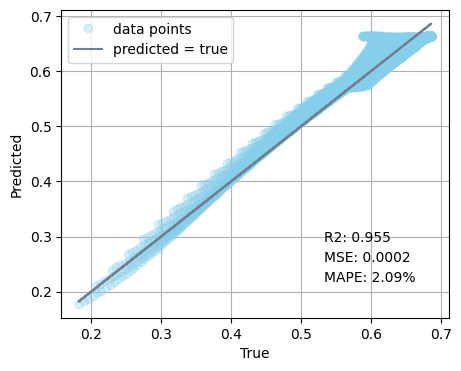

In [50]:
fig = plt.figure(figsize=(5,4))
plt.plot(y, y_pred, 'o',label='data points',color='skyblue', alpha=0.3)
plt.plot(y, y, 'slategrey', label='predicted = true')
plt.text(0.65, 0.3, f'R2: {r2_score(y, y_pred):.3f}', transform=fig.transFigure)
plt.text(0.65, 0.25, f'MSE: {mean_squared_error(y, y_pred):.4f}', transform=fig.transFigure)
plt.text(0.65, 0.20, f'MAPE: {mape:.2f}%', transform=fig.transFigure)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
#plt.ylim(-2,2)
#plt.xlim(-2,2)
#plt.title(f"Predicted vs True $\\Delta \\Phi$ of {substance}")
plt.grid()
plt.show()

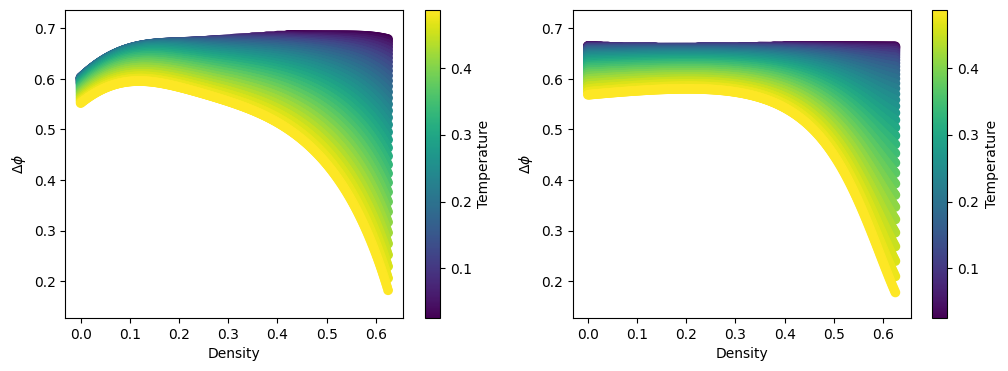

In [51]:
ymax = max(y_pred.max(), data_p['delta_phi'].max())+0.05
ymin = min(y_pred.min(), data_p['delta_phi'].min())-0.05
fig = plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
scatter = plt.scatter(data_p['density'], data_p['delta_phi'], c=data_p['temperature'], cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Temperature')
plt.xlabel('Density')
#plt.xlim(-0.1, 1)
plt.ylim(ymin, ymax)
plt.ylabel('$\\Delta \\phi$')
# plot phi = -0.4
#plt.axhline(y=-0.27, color='r', linestyle='--')
#plt.axhline(y=0, color='r', linestyle='--')
#plt.title(f'{substance} True')
plt.subplot(1,2,2)
scatter = plt.scatter(data_p['density'], y_pred, c=data_p['temperature'], cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Temperature')
plt.xlabel('Density')
plt.ylabel('$\\Delta \\phi$')
#plt.title(f'{substance} Predicted')
plt.ylim(ymin, ymax)
#plt.xlim(-0.1, 1)
#plt.axhline(y=-0.45, color='r', linestyle='--')
#plt.axhline(y=0, color='r', linestyle='--')
plt.show()

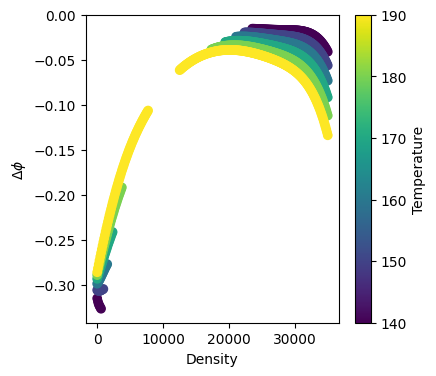

In [8]:
data_pl = methane[(methane['temperature']>=0) & (methane['temperature']<=190)]
fig = plt.figure(figsize=(9, 4))
plt.subplot(1,2,1)
scatter = plt.scatter(data_pl['density'], data_pl['delta_phi'], c=data_pl['temperature'], cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Temperature')
plt.xlabel('Density')
#plt.xlim(-5000,60000)
#plt.ylim(-3, 7)
plt.ylabel('$\\Delta \\phi$')
plt.show()

In [52]:
best_model = model.get_best()
print(best_model)


complexity                                                                                                                                                    21
loss                                                                                                                                                    0.000363
score                                                                                                                                                   0.102413
equation              cos(sinh(sinh(temperature) / exp(sin(exp(density) / (cos(Boiling_Point) - -0.044939317)) * (square(density) + 0.19715942)))) + -0.33475593
sympy_format                      cos(sinh(exp(-(density**2 + 0.19715942)*sin(exp(density)/(cos(Boiling_Point) + 0.044939317)))*sinh(temperature))) - 0.33475593
lambda_format    PySRFunction(X=>cos(sinh(exp(-(density**2 + 0.19715942)*sin(exp(density)/(cos(Boiling_Point) + 0.044939317)))*sinh(temperature))) - 0.33475593)
Name: 18, dtype: object


In [26]:
print(model.latex())

temperature^{2} \left(Melting_{Point} density^{4} e^{\sin{\left(Boiling_{Point} \right)}} - Molecular_{Weight}\right) 0.0218 - -0.669


In [33]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# Define a dictionary with the SMILES representations and properties
substances = {
    "argon": {
        "SMILES": "Ar",
        "Molecular_Weight": 39.948,
        "Boiling_Point": -185.7,  # °C
        "Melting_Point": -189.3   # °C
    },
    "methane": {
        "SMILES": "C",
        "Molecular_Weight": None,  # Will calculate
        "Density": 0.000717,  # g/cm³
        "Boiling_Point": -161.5,  # °C
        "Melting_Point": -182.5   # °C
    },
    "water": {
        "SMILES": "O",
        "Molecular_Weight": 18.01528,
        "Boiling_Point": 100.0,  # °C
        "Melting_Point": 0.0   # °C
    }
}

# Create a DataFrame to hold the features
features = []

for name, props in substances.items():
    if props["Molecular_Weight"] is None:
        mol = Chem.MolFromSmiles(props["SMILES"])
        props["Molecular_Weight"] = Descriptors.MolWt(mol) if mol else None
    
    features.append({
        'substance': name,
        'SMILES': props["SMILES"],
        'Molecular_Weight': props["Molecular_Weight"],
        'Boiling_Point': props["Boiling_Point"],
        'Melting_Point': props["Melting_Point"],
    })

# Create a DataFrame from the features
features_df = pd.DataFrame(features)
print(features_df)
features_df.to_csv('data/processed_data/supplementary_features_3.csv', index=False)



  substance SMILES  Molecular_Weight  Boiling_Point  Melting_Point
0     argon     Ar          39.94800         -185.7         -189.3
1   methane      C          16.04300         -161.5         -182.5
2     water      O          18.01528          100.0            0.0


In [34]:
combined_data = pd.read_csv('data/processed_data/combined_data_3.csv')
supplementary_features = pd.read_csv('data/processed_data/supplementary_features_3.csv')

In [35]:
combined_data['substance'].unique()

array(['water', 'methane', 'argon'], dtype=object)

### Test DSO

In [ ]:
from dso import DeepSymbolicRegressor

# Generate some data
np.random.seed(0)
X = np.random.random((10, 2))
y = np.sin(X[:,0]) + X[:,1] ** 2

# Create the model
model = DeepSymbolicRegressor() # Alternatively, you can pass in your own config JSON path

# Fit the model
model.fit(X, y) # Should solve in ~10 seconds

# View the best expression
print(model.program_.pretty())

# Make predictions
model.predict(2 * X)


: 

In [4]:
import dso
print(dir(dso))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


In [44]:
# remove folder venv3
import os
os.system('rm -rf venv3')

0

In [55]:
def formula_constraint_0(data):
    data.loc[data['density'] < 0.001, 'delta_phi'] = 0
    temperatures = data['temperature'].unique()
    # Step 2: Get unique substance parameters, filter out rows with missing values
    new_data = data[['temperature','Boiling_Point', 'Molecular_Weight', 'Melting_Point']].drop_duplicates()
    new_data['density'] = 10000
    new_data['delta_phi'] = 0
    data = pd.concat([data, new_data], ignore_index=True)
    return data

In [56]:
total_data_features_0 = formula_constraint_0(total_data_features)

In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Create a molecule from SMILES (Simplified Molecular Input Line Entry System)
h2o_mol = Chem.MolFromSmiles('[Ar]')

# Calculate Molecular Weight
mol_weight = Descriptors.MolWt(h2o_mol)

# Calculate Topological Polar Surface Area (TPSA)
tpsa = Descriptors.TPSA(h2o_mol)

# Display the results
print(f"Molecular Weight: {mol_weight}")
print(f"Topological Polar Surface Area (TPSA): {tpsa}")


Molecular Weight: 39.948
Topological Polar Surface Area (TPSA): 0.0
